In [3]:
# =============================
# 0) Mount Google Drive
# =============================
from google.colab import drive
drive.mount('/content/drive')

# =============================
# 1) Imports
# =============================
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

# =============================
# 2) Paths + planets
# =============================
DATA_DIR = "/content/drive/My Drive/UV_IR_data"
OUT_DIR  = "/content/drive/My Drive/UV_IR_data/barcode_outputs"

PLANETS = ["jupiter", "mars", "neptune", "venus", "saturn", "uranus"]

os.makedirs(OUT_DIR, exist_ok=True)

# =============================
# 3) Load .pkl
# =============================
def load_pkl(path: str):
    with open(path, "rb") as f:
        return pickle.load(f)

# =============================
# 4) Convert any pkl structure to standard df[wavelength, flux]
#    (supports your columns like wavelength_um, flux_mjy_sr)
# =============================
def to_spectrum_df(obj):
    # ---- DataFrame ----
    if isinstance(obj, pd.DataFrame):
        cols = {c.lower(): c for c in obj.columns}

        wl_candidates = [
            "wavelength", "wave", "wl", "lambda", "lam",
            "wavelength_um", "wavelength_nm", "wavelength_m"
        ]
        fx_candidates = [
            "flux", "intensity", "radiance", "reflectance", "spec", "spectrum",
            "flux_mjy_sr", "flux_jy", "flux_jy_sr", "flux_density", "f"
        ]

        wl = next((cols[k] for k in wl_candidates if k in cols), None)
        fx = next((cols[k] for k in fx_candidates if k in cols), None)

        if wl is None or fx is None:
            raise ValueError(f"Cannot detect wavelength/flux columns. Columns={obj.columns.tolist()}")

        return obj[[wl, fx]].rename(columns={wl: "wavelength", fx: "flux"}).copy()

    # ---- dict ----
    if isinstance(obj, dict):
        keys = {str(k).lower(): k for k in obj.keys()}

        wl_candidates = ["wavelength", "wave", "wl", "lambda", "lam", "wavelength_um", "wavelength_nm"]
        fx_candidates = ["flux", "intensity", "radiance", "reflectance", "spec", "spectrum", "flux_mjy_sr", "flux_jy", "f"]

        wl_k = next((keys[k] for k in wl_candidates if k in keys), None)
        fx_k = next((keys[k] for k in fx_candidates if k in keys), None)

        if wl_k is None or fx_k is None:
            raise ValueError(f"Cannot detect wavelength/flux keys. Keys={list(obj.keys())[:30]}")

        return pd.DataFrame({
            "wavelength": np.asarray(obj[wl_k], dtype=float),
            "flux": np.asarray(obj[fx_k], dtype=float)
        })

    # ---- ndarray ----
    if isinstance(obj, np.ndarray):
        arr = np.asarray(obj)
        if arr.ndim == 2 and arr.shape[1] >= 2:
            return pd.DataFrame({
                "wavelength": arr[:, 0].astype(float),
                "flux": arr[:, 1].astype(float)
            })

    raise ValueError(f"Unsupported pickle format: {type(obj)}")

# =============================
# 5) Clean + Smooth spectrum
# =============================
def preprocess(df: pd.DataFrame):
    w = df["wavelength"].to_numpy(dtype=float)
    f = df["flux"].to_numpy(dtype=float)

    mask = np.isfinite(w) & np.isfinite(f)
    w, f = w[mask], f[mask]

    order = np.argsort(w)
    w, f = w[order], f[order]

    # remove duplicate wavelengths
    _, idx = np.unique(w, return_index=True)
    w, f = w[idx], f[idx]

    # Savitzky-Golay smoothing
    if len(f) > 7:
        window = min(31, len(f) - 1)
        if window % 2 == 0:
            window -= 1
        if window < 5:
            window = 5
        poly = 3
        if poly >= window:
            poly = max(2, window - 2)
        f = savgol_filter(f, window_length=window, polyorder=poly)

    return w, f

def norm01(x: np.ndarray):
    lo, hi = float(np.min(x)), float(np.max(x))
    if hi - lo < 1e-12:
        return np.zeros_like(x)
    return (x - lo) / (hi - lo)

# =============================
# 6) Make ONE barcode per planet (UV+IR merged; not separated in results)
#    NOTE: UV and IR are normalized separately before merging (important if units differ).
# =============================
def make_barcode(planet: str, uv_df: pd.DataFrame, ir_df: pd.DataFrame):
    w_uv, f_uv = preprocess(uv_df)
    w_ir, f_ir = preprocess(ir_df)

    # Normalize UV and IR separately so neither dominates (units often differ)
    n_uv = norm01(f_uv)
    n_ir = norm01(f_ir)

    # Merge into a single fingerprint
    w_all = np.concatenate([w_uv, w_ir])
    n_all = np.concatenate([n_uv, n_ir])

    # Sort by wavelength
    order = np.argsort(w_all)
    w_all = w_all[order]
    n_all = n_all[order]

    # Absorption darker
    intensity = 1.0 - n_all

    # Build 2D strip
    strip_height = 60
    strip = np.tile(intensity, (strip_height, 1))

    # Plot
    plt.figure(figsize=(12, 2.2))
    plt.imshow(strip, aspect="auto", origin="lower", cmap="viridis")
    plt.xticks([])
    plt.yticks([])
    plt.title(f"{planet.capitalize()} — Combined UV+IR Spectral Fingerprint (Barcode)")
    plt.tight_layout()

    out_path = os.path.join(OUT_DIR, f"{planet}_barcode.png")
    plt.savefig(out_path, dpi=300, bbox_inches="tight")
    plt.close()

    print("Saved:", out_path)

# =============================
# 7) Run for all planets
# =============================
for planet in PLANETS:
    uv_path = os.path.join(DATA_DIR, f"{planet}_uv.pkl")
    ir_path = os.path.join(DATA_DIR, f"{planet}_ir.pkl")

    if not os.path.exists(uv_path):
        print(f"[SKIP] Missing UV file for {planet}: {uv_path}")
        continue
    if not os.path.exists(ir_path):
        print(f"[SKIP] Missing IR file for {planet}: {ir_path}")
        continue

    uv_obj = load_pkl(uv_path)
    ir_obj = load_pkl(ir_path)

    uv_df = to_spectrum_df(uv_obj)
    ir_df = to_spectrum_df(ir_obj)

    make_barcode(planet, uv_df, ir_df)

print("\nDone. Check output folder:\n", OUT_DIR)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/tmp/ipython-input-3884512800.py:32: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.load(f)


Saved: /content/drive/My Drive/UV_IR_data/barcode_outputs/jupiter_barcode.png


/tmp/ipython-input-3884512800.py:32: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.load(f)


Saved: /content/drive/My Drive/UV_IR_data/barcode_outputs/mars_barcode.png


/tmp/ipython-input-3884512800.py:32: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.load(f)


Saved: /content/drive/My Drive/UV_IR_data/barcode_outputs/neptune_barcode.png


/tmp/ipython-input-3884512800.py:32: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.load(f)


Saved: /content/drive/My Drive/UV_IR_data/barcode_outputs/venus_barcode.png


/tmp/ipython-input-3884512800.py:32: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.load(f)


Saved: /content/drive/My Drive/UV_IR_data/barcode_outputs/saturn_barcode.png
Saved: /content/drive/My Drive/UV_IR_data/barcode_outputs/uranus_barcode.png

Done. Check output folder:
 /content/drive/My Drive/UV_IR_data/barcode_outputs


/tmp/ipython-input-3884512800.py:32: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.load(f)
/tmp/ipython-input-3884512800.py:32: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use t

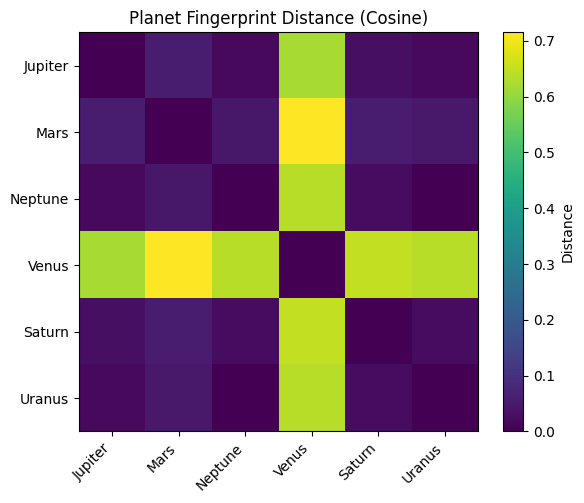

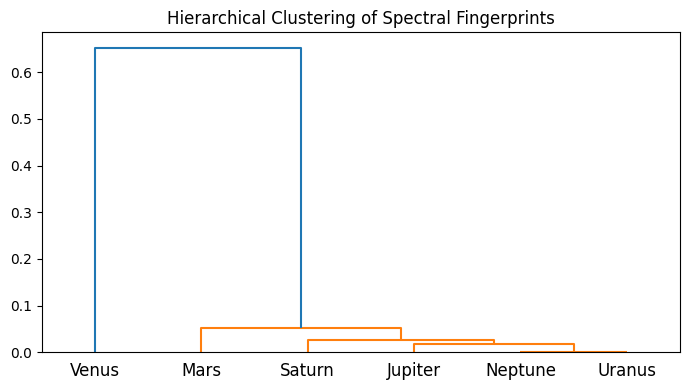

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram

# Use same paths/planets as before
DATA_DIR = "/content/drive/My Drive/UV_IR_data"
PLANETS = ["jupiter", "mars", "neptune", "venus", "saturn", "uranus"]

# ---- reuse your loaders from previous cell ----
# assumes load_pkl, to_spectrum_df, preprocess, norm01 already defined

def get_normalized_fingerprint(planet):
    uv_path = os.path.join(DATA_DIR, f"{planet}_uv.pkl")
    ir_path = os.path.join(DATA_DIR, f"{planet}_ir.pkl")

    uv_df = to_spectrum_df(load_pkl(uv_path))
    ir_df = to_spectrum_df(load_pkl(ir_path))

    w_uv, f_uv = preprocess(uv_df)
    w_ir, f_ir = preprocess(ir_df)

    n_uv = norm01(f_uv)
    n_ir = norm01(f_ir)

    w = np.concatenate([w_uv, w_ir])
    n = np.concatenate([n_uv, n_ir])

    order = np.argsort(w)
    return w[order], n[order]

# 1) Build a COMMON wavelength grid (intersection range)
ws = []
ns = []
wmins, wmaxs = [], []

for p in PLANETS:
    w, n = get_normalized_fingerprint(p)
    ws.append(w); ns.append(n)
    wmins.append(w.min()); wmaxs.append(w.max())

w_min = max(wmins)
w_max = min(wmaxs)

grid = np.linspace(w_min, w_max, 2000)  # common grid

X = []
for p, w, n in zip(PLANETS, ws, ns):
    f = interp1d(w, n, kind="linear", bounds_error=False, fill_value="extrapolate")
    X.append(f(grid))
X = np.vstack(X)

# 2) Similarity (cosine distance) + heatmap
D = squareform(pdist(X, metric="cosine"))

plt.figure(figsize=(6,5))
plt.imshow(D, aspect="equal")
plt.xticks(range(len(PLANETS)), [p.capitalize() for p in PLANETS], rotation=45, ha="right")
plt.yticks(range(len(PLANETS)), [p.capitalize() for p in PLANETS])
plt.title("Planet Fingerprint Distance (Cosine)")
plt.colorbar(label="Distance")
plt.tight_layout()
plt.show()

# 3) Clustering dendrogram
Z = linkage(X, method="average", metric="cosine")
plt.figure(figsize=(7,4))
dendrogram(Z, labels=[p.capitalize() for p in PLANETS])
plt.title("Hierarchical Clustering of Spectral Fingerprints")
plt.tight_layout()
plt.show()


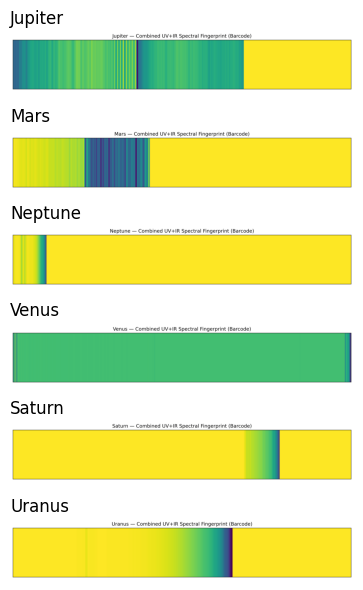

In [13]:
plt.figure(figsize=(12,6))

for i, planet in enumerate(PLANETS):
    img = plt.imread(f"{OUT_DIR}/{planet}_barcode.png")
    plt.subplot(len(PLANETS), 1, i+1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(planet.capitalize(), loc="left")

plt.tight_layout()
plt.show()
